In [2]:
ls

sample_data/


In [3]:
!mkdir .kaggle

import json
token = {"username":"d3nyal","key":"06085d4b617ede5ada5ba93698311ef8"}
with open('/content/.kaggle/kaggle.json','w') as file:
    json.dump(token,file)

!mkdir ~/.kaggle

!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}

!kaggle competitions download -c dogs-vs-cats -p/content

!unzip -q test1.zip -d .
!unzip -q train.zip -d .

- path is now set to: {/content}
  0% 0.00/86.8k [00:00<?, ?B/s]
100% 86.8k/86.8k [00:00<00:00, 33.3MB/s]
 99% 537M/543M [00:05<00:00, 133MB/s]
100% 543M/543M [00:05<00:00, 102MB/s]
 93% 253M/271M [00:03<00:00, 76.3MB/s]
100% 271M/271M [00:03<00:00, 81.7MB/s]


In [4]:
ls

sample_data/  sampleSubmission.csv  test1/  test1.zip  train/  train.zip


In [5]:
import os
import pandas as pd

filenames = os.listdir('/content/train/')
categories = []

for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [6]:
df.category = df.category.map(
    {
        0: '0',
        1: '1'
    }
)

df.head()

,filename,category
0,dog.7074.jpg,1
1,dog.848.jpg,1
2,dog.11684.jpg,1
3,cat.1056.jpg,0
4,dog.6242.jpg,1


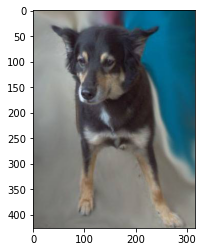

In [7]:
from matplotlib import pyplot as plt
from keras.preprocessing.image import load_img
import random

sample = random.choice(filenames)
image = load_img("/content/train/"+sample)
plt.imshow(image)


In [8]:
from sklearn.model_selection import train_test_split

train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [9]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)


train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "/content/train/", 
    x_col='filename',
    y_col='category',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32
)

Found 20000 validated image filenames belonging to 2 classes.


In [10]:
validate_df

,filename,category
0,dog.11453.jpg,1
1,cat.3697.jpg,0
2,cat.12084.jpg,0
3,cat.3202.jpg,0
4,cat.285.jpg,0
...,...,...
4995,dog.5567.jpg,1
4996,dog.10033.jpg,1
4997,cat.8490.jpg,0
4998,cat.5607.jpg,0


In [11]:
validation_datagen = ImageDataGenerator(
    rescale=1./255,
)

validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "/content/train/", 
    x_col='filename',
    y_col='category',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32
)

Found 5000 validated image filenames belonging to 2 classes.


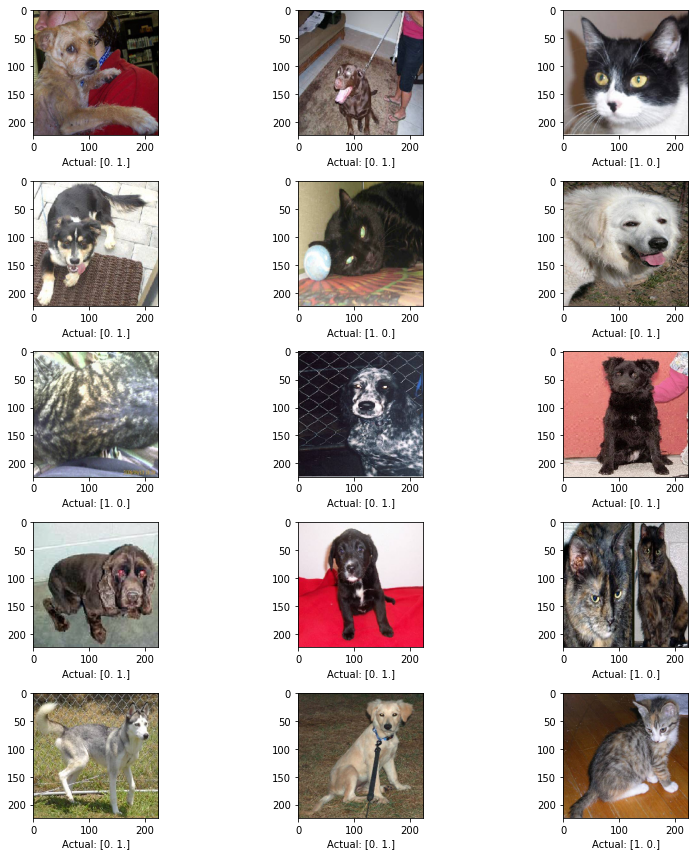

In [88]:
plt.figure(figsize=(12, 12))

for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in validation_generator:
        image = X_batch[0]
        plt.xlabel("Actual: " + str(Y_batch[0]))
        plt.imshow(image)
        break

plt.tight_layout()
plt.show()

In [64]:
from keras.models import Sequential
from keras.regularizers import l2
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(64, kernel_size=5, kernel_initializer='he_uniform', padding='same', input_shape=(224, 224, 3)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Conv2D(128, kernel_size=3, strides=2, kernel_initializer='he_uniform'))
model.add(Activation('elu'))
model.add(MaxPooling2D(2, 2))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Conv2D(64, kernel_size=3, kernel_initializer='he_uniform', padding='same'))
model.add(Activation('elu'))
model.add(MaxPooling2D(2, 2))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Conv2D(128, kernel_size=5, strides=2, kernel_initializer='he_uniform', padding='same'))
model.add(Activation('elu'))
model.add(MaxPooling2D(2, 2))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Flatten())

model.add(Dense(756, kernel_initializer='he_uniform'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(256, kernel_initializer='he_uniform'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(2, kernel_initializer='he_uniform'))
model.add(Activation('sigmoid'))

model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           (None, 224, 224, 64)      4864      
_________________________________________________________________
activation_60 (Activation)   (None, 224, 224, 64)      0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 224, 224, 64)      256       
_________________________________________________________________
dropout_46 (Dropout)         (None, 224, 224, 64)      0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 111, 111, 128)     73856     
_________________________________________________________________
activation_61 (Activation)   (None, 111, 111, 128)     0         
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 55, 55, 128)     

In [65]:
model.compile(
    loss = 'binary_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy'])

In [66]:
history = model.fit(
    train_generator, 
    epochs=10,
    validation_data=validation_generator,
)

Epoch 1/10
625/625 [==============================] - 261s 418ms/step - loss: 0.6633 - accuracy: 0.6611 - val_loss: 0.4954 - val_accuracy: 0.7772
Epoch 2/10
625/625 [==============================] - 261s 418ms/step - loss: 0.4978 - accuracy: 0.7635 - val_loss: 0.3951 - val_accuracy: 0.8322
Epoch 3/10
625/625 [==============================] - 261s 417ms/step - loss: 0.4391 - accuracy: 0.8000 - val_loss: 0.3694 - val_accuracy: 0.8384
Epoch 4/10
625/625 [==============================] - 261s 417ms/step - loss: 0.4034 - accuracy: 0.8195 - val_loss: 0.3416 - val_accuracy: 0.8442
Epoch 5/10
625/625 [==============================] - 261s 417ms/step - loss: 0.3707 - accuracy: 0.8367 - val_loss: 0.2973 - val_accuracy: 0.8744
Epoch 6/10
625/625 [==============================] - 261s 417ms/step - loss: 0.3350 - accuracy: 0.8558 - val_loss: 0.2724 - val_accuracy: 0.8892
Epoch 7/10
625/625 [==============================] - 260s 416ms/step - loss: 0.3083 - accuracy: 0.8691 - val_loss: 0.2605 -

accuracy: 92.22%


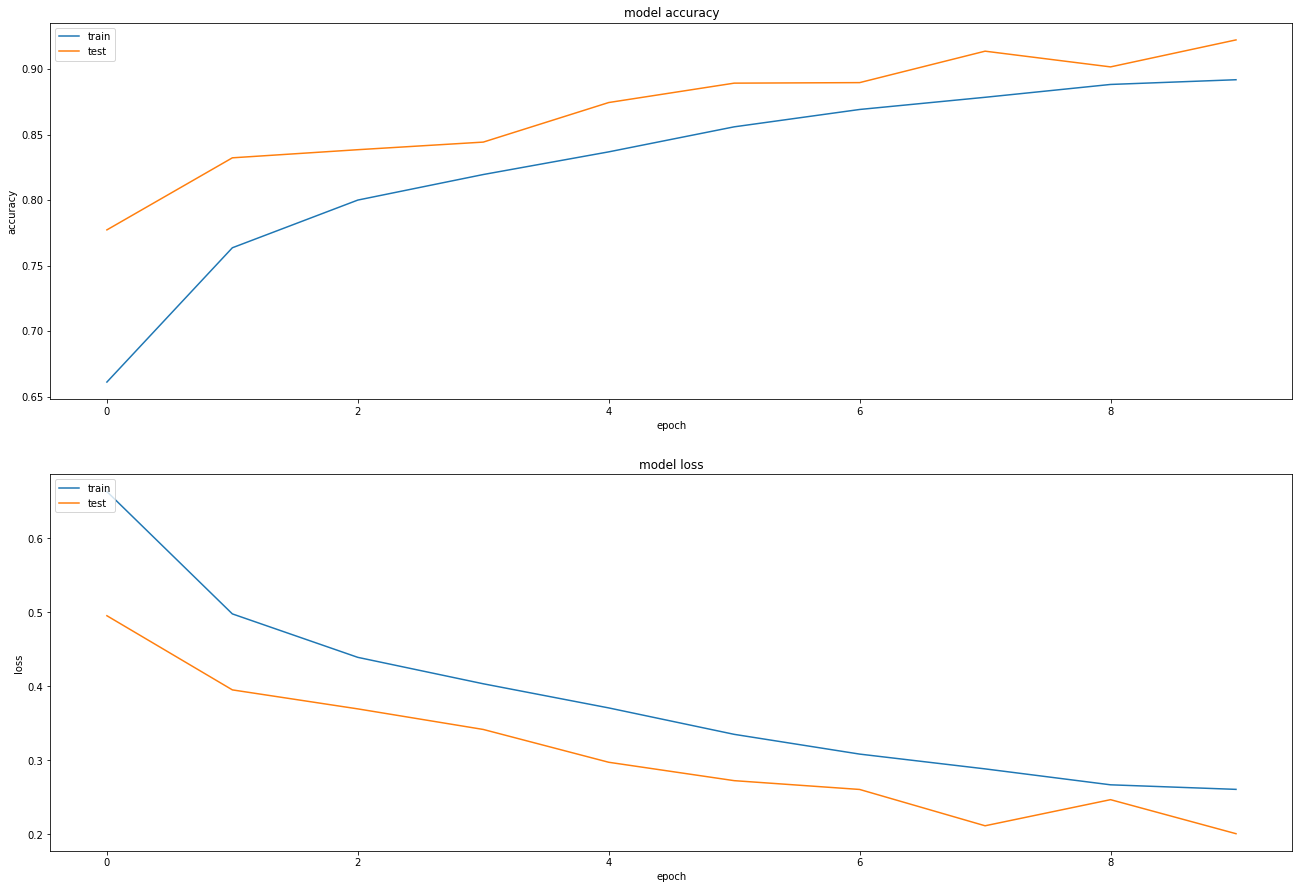

In [67]:
score = model.evaluate(validation_generator, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

# summarize history for accuracy  
   
plt.subplot(211)  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
  
# summarize history for loss  
   
plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  

plt.subplots_adjust(right=3, top=3)
plt.show()

In [69]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [70]:
cd gdrive/My\ Drive/Temp/Cats\ vs\ Dogs

/content/gdrive/My Drive/Temp/Cats vs Dogs


In [71]:
model.save('catsvsdogs_10epochs_92.h5')

In [72]:
ls

catsvsdogs_10epochs_92.h5


In [73]:
history = model.fit(
    train_generator, 
    epochs=15,
    validation_data=validation_generator,
)

Epoch 1/15
625/625 [==============================] - 263s 421ms/step - loss: 0.2510 - accuracy: 0.8935 - val_loss: 0.2395 - val_accuracy: 0.8972
Epoch 2/15
625/625 [==============================] - 266s 426ms/step - loss: 0.2378 - accuracy: 0.9007 - val_loss: 0.2597 - val_accuracy: 0.8826
Epoch 3/15
625/625 [==============================] - 263s 420ms/step - loss: 0.2306 - accuracy: 0.9051 - val_loss: 0.1910 - val_accuracy: 0.9314
Epoch 4/15
625/625 [==============================] - 261s 418ms/step - loss: 0.2240 - accuracy: 0.9086 - val_loss: 0.1935 - val_accuracy: 0.9244
Epoch 5/15
625/625 [==============================] - 261s 417ms/step - loss: 0.2160 - accuracy: 0.9126 - val_loss: 0.1680 - val_accuracy: 0.9374
Epoch 6/15
625/625 [==============================] - 261s 418ms/step - loss: 0.2119 - accuracy: 0.9147 - val_loss: 0.2322 - val_accuracy: 0.9056
Epoch 7/15
625/625 [==============================] - 261s 417ms/step - loss: 0.2028 - accuracy: 0.9206 - val_loss: 0.1629 -

accuracy: 94.64%


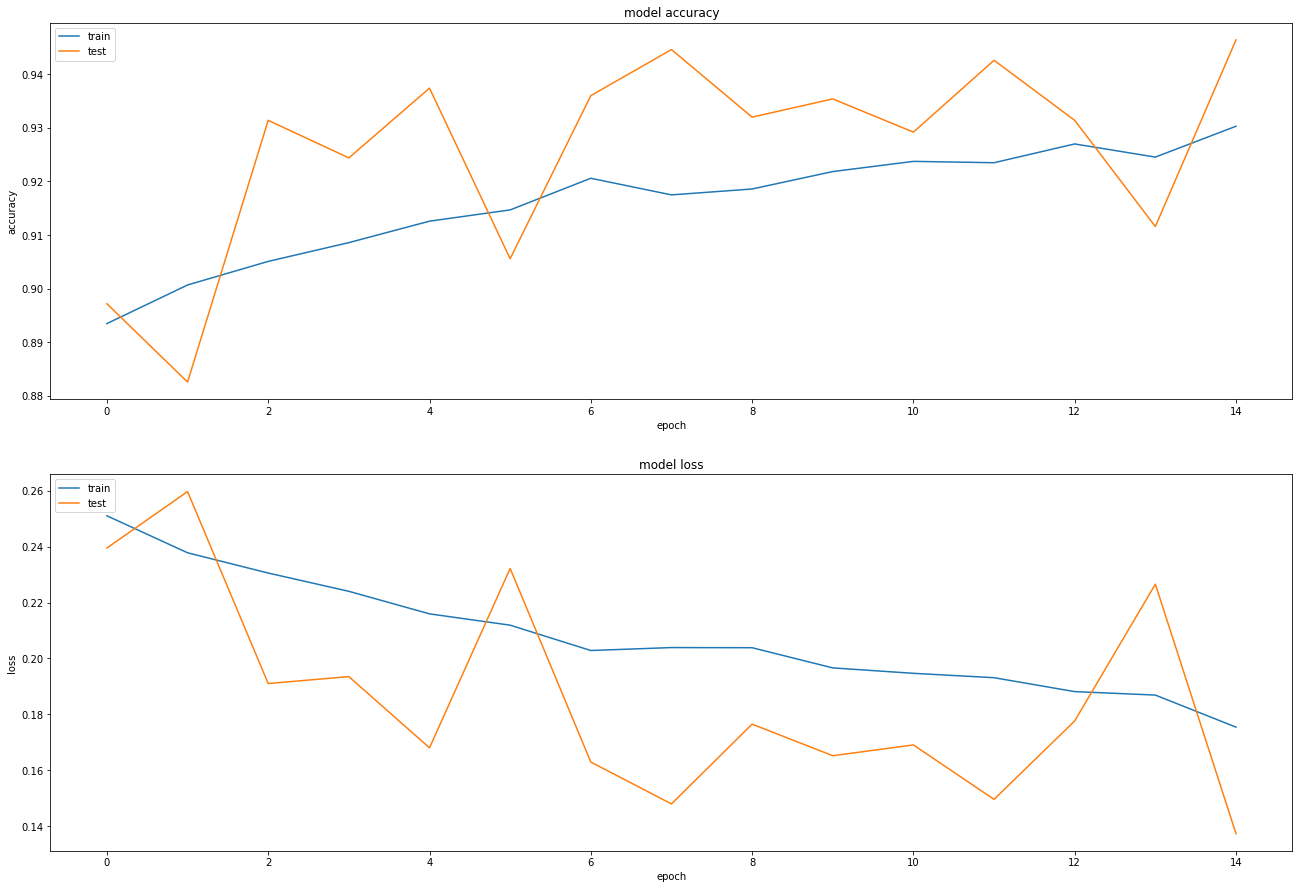

In [74]:
score = model.evaluate(validation_generator, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

# summarize history for accuracy  
   
plt.subplot(211)  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
  
# summarize history for loss  
   
plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  

plt.subplots_adjust(right=3, top=3)
plt.show()

In [114]:
ls

catsvsdogs_10epochs_92.h5


In [117]:
model.save('catsvsdogs_25epochs_94-6.h5')

In [118]:
ls

catsvsdogs_10epochs_92.h5  catsvsdogs_25epochs_94-6.h5


In [119]:
history = model.fit(
    train_generator, 
    epochs=25,
    validation_data=validation_generator,
)

Epoch 1/25
625/625 [==============================] - 263s 421ms/step - loss: 0.1782 - accuracy: 0.9311 - val_loss: 0.1649 - val_accuracy: 0.9376
Epoch 2/25
625/625 [==============================] - 263s 420ms/step - loss: 0.1760 - accuracy: 0.9293 - val_loss: 0.1546 - val_accuracy: 0.9464
Epoch 3/25
625/625 [==============================] - 263s 421ms/step - loss: 0.1754 - accuracy: 0.9320 - val_loss: 0.1332 - val_accuracy: 0.9482
Epoch 4/25
625/625 [==============================] - 261s 418ms/step - loss: 0.1718 - accuracy: 0.9327 - val_loss: 0.1272 - val_accuracy: 0.9528
Epoch 5/25
625/625 [==============================] - 259s 415ms/step - loss: 0.1667 - accuracy: 0.9341 - val_loss: 0.1545 - val_accuracy: 0.9402
Epoch 6/25
625/625 [==============================] - 259s 415ms/step - loss: 0.1659 - accuracy: 0.9351 - val_loss: 0.1510 - val_accuracy: 0.9448
Epoch 7/25
625/625 [==============================] - 259s 415ms/step - loss: 0.1669 - accuracy: 0.9363 - val_loss: 0.1443 -

In [120]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


accuracy: 95.82%


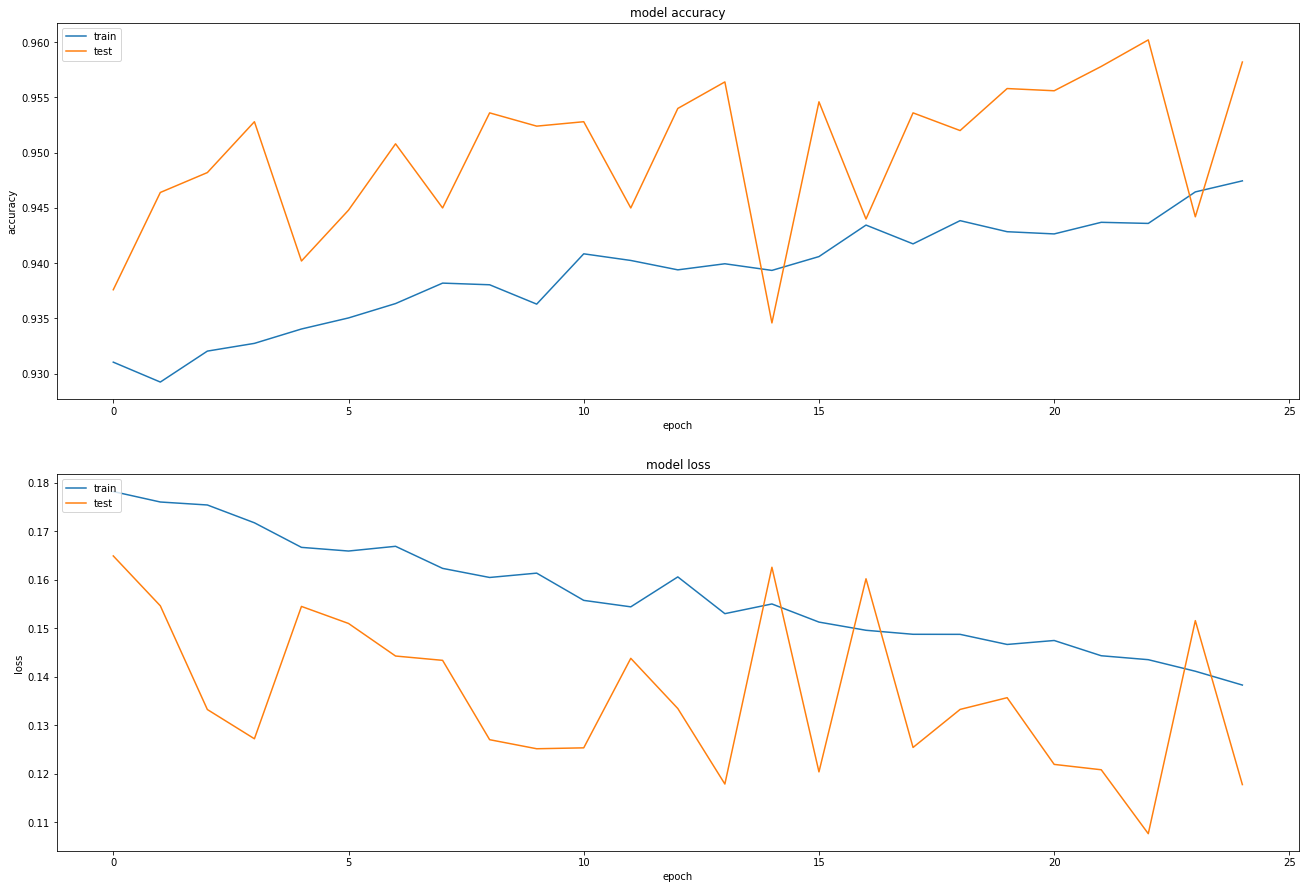

In [121]:
score = model.evaluate(validation_generator, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

# summarize history for accuracy  
   
plt.subplot(211)  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
  
# summarize history for loss  
   
plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  

plt.subplots_adjust(right=3, top=3)
plt.show()